In [4]:
!pip install cowsay

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3 -m pip install --upgrade pip' command.


In [1]:
%matplotlib inline
import numpy as np
import cv2
import os
import pandas as pd
from tqdm import tqdm
import imutils
import Augmentor
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D , BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from matplotlib import pyplot as plt
from skimage.morphology import extrema
from skimage.morphology import watershed as skwater

In [6]:
import cowsay
cowsay.cow("Wssup dude")

  __________
| Wssup dude |
          \
           \
             ^__^
             (oo)\_______
             (__)\       )\/\
                 ||----w |
                 ||     ||


In [7]:
path1 = './TRAINING/INMEYOK/PNG/output'
path2 = './TRAINING/KANAMA/PNG/output'
path3 = './TRAINING/ISKEMI/PNG/output'
path11 = './TRAINING/INMEYOK/PNG/output/output'
path22 = './TRAINING/KANAMA/PNG/output/output'
path33 = './TRAINING/ISKEMI/PNG/output/output'

In [7]:
"""p = Augmentor.Pipeline(path1)
p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
p.zoom(probability=0.3, min_factor=1.1, max_factor=1.6)
p.sample(10000)"""

Executing Pipeline:   0%|          | 0/10000 [00:00<?, ? Samples/s]

Initialised with 4427 image(s) found.
Output directory set to ./TRAINING/INMEYOK/PNG/output/output.

Processing <PIL.Image.Image image mode=RGBA size=512x512 at 0x7FBA3C8653C8>: 100%|██████████| 10000/10000 [01:22<00:00, 121.26 Samples/s]               


In [8]:
"""p = Augmentor.Pipeline(path2)
p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
p.zoom(probability=0.3, min_factor=1.1, max_factor=1.6)
p.sample(5000)"""

Executing Pipeline:   0%|          | 0/5000 [00:00<?, ? Samples/s]

Initialised with 1093 image(s) found.
Output directory set to ./TRAINING/KANAMA/PNG/output/output.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=512x512 at 0x7FBA3BB77B38>: 100%|██████████| 5000/5000 [00:40<00:00, 122.12 Samples/s]


In [9]:
"""p = Augmentor.Pipeline(path3)
p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
p.zoom(probability=0.3, min_factor=1.1, max_factor=1.6)
p.sample(5000)"""

Executing Pipeline:   0%|          | 0/5000 [00:00<?, ? Samples/s]

Initialised with 1130 image(s) found.
Output directory set to ./TRAINING/ISKEMI/PNG/output/output.

Processing <PIL.Image.Image image mode=RGBA size=512x512 at 0x7FBA3A9B03C8>: 100%|██████████| 5000/5000 [00:37<00:00, 131.86 Samples/s]                


In [10]:
def crop_brain_contour(image, plot=False):

    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    # extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()

    return new_image

In [73]:
#columns=["image", "label"]
negative_list = []
positive_list = []
label_list = []
errorr=0
counter = 0
def loaddata(path, label, image_list):
    all_images = os.listdir(path)
    for image in tqdm(all_images):
        img = cv2.imread(os.path.join(path, image))
        #kernel = np.ones((8,8),np.uint8)
        #img2 = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
        try:
            img = crop_brain_contour(img)
            img = cv2.resize(img,(240,240))
            br_out = img
            gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
            ret, thresh = cv2.threshold(gray,220, 255, cv2.THRESH_TOZERO_INV)
            colormask = np.zeros(img.shape, dtype=np.uint8)
            colormask[thresh!=0] = np.array((0,0,255))
            blended = cv2.addWeighted(img,0.7,colormask,0.1,0)
            ret, markers = cv2.connectedComponents(thresh)

            #Get the area taken by each component. Ignore label 0 since this is the background.
            marker_area = [np.sum(markers==m) for m in range(np.max(markers)) if m!=0] 
            #Get label of largest component by area
            largest_component = np.argmax(marker_area)+1 #Add 1 since we dropped zero above                        
            #Get pixels which correspond to the brain
            brain_mask = markers==largest_component

            brain_out = img.copy()
            #In a copy of the original image, clear those pixels that don't correspond to the brain
            brain_out[brain_mask==False] = (0,0,0)
            brain_mask = np.uint8(brain_mask)
            kernel = np.ones((8,8),np.uint8)
            closing = cv2.morphologyEx(brain_mask, cv2.MORPH_CLOSE, kernel)
            brain_out = img.copy()
            #In a copy of the original image, clear those pixels that don't correspond to the brain
            brain_out[closing==False] = (0,0,0)
            #img = crop_brain_contour(img)
            #img = cv2.resize(img,(240,240))
            #br_out = crop_brain_contour(brain_out)
            #br_out = cv2.resize(br_out,(240,240))
            number_of_white_pix_img = np.sum(img != 0)
            number_of_black_pix_img = np.sum(img == 0)
            ratio_img = (number_of_white_pix_img/number_of_black_pix_img)*100
            
            number_of_white_pix_brain = np.sum(brain_out[120:, :] != 0)
            number_of_black_pix_brain = np.sum(brain_out[120:, :] == 0)
            ratio_brain = (number_of_white_pix_brain/number_of_black_pix_brain)*100
        except:
            #plt.imshow(img)
            #plt.title("eeeeeee")
            #print(errorr)
            #errorr += 1
            continue
           
            #brain_out = brain_out/255.0
        if ratio_img >= 20:
            image_list.append(img)
        if ratio_brain >= 20:
            negative_list.append(brain_out)
        #counter += 1
            
        #negative_list.append(brain_out)
        #image_list.append(img)
        label_list.append(label)    

In [74]:
"""
loaddata("./DATA/TRAIN/Var/", 1, positive_list)
loaddata("./DATA/TRAIN/Yok/", 0, positive_list)
loaddata("./DATA/VAL/Var/", 1, positive_list)
loaddata("./DATA/VAL/Yok/", 0, positive_list)
loaddata("./DATA/TEST/Var/", 1, positive_list)
loaddata("./DATA/TEST/Yok/", 0, positive_list)
"""
loaddata(path11, 0, positive_list)
#loaddata(path2, 1, positive_list)
#loaddata(path3, 1, positive_list)
#dict = {"image":image_list, "label":label_list}
#data = pd.DataFrame(dict)

100%|██████████| 10000/10000 [01:35<00:00, 104.64it/s]


In [75]:
len(positive_list)

9998

In [60]:
positive_list[1].shape

(240, 240, 3)

In [61]:
label_list1=label_list

In [62]:
len(label_list1)

9998

In [76]:
len(negative_list)

9031

In [49]:
plt.imshow(negative_list[6243][120:, :])

SyntaxError: invalid syntax (<ipython-input-49-aaf8437bf1fe>, line 1)

In [30]:
#plt.imshow(positive_list[0])

In [47]:
white = np.sum(negative_list[6243][120:, :] != 0)
black = np.sum(negative_list[6243][120:, :] == 0)
print("white = " + str(white) + ", black = " + str(black), "ratio = %", str((white/black)*100))

white = 17283, black = 69117 ratio = % 25.005425582707584


In [24]:
white = np.sum(negative_list[6011] != 0)
black = np.sum(negative_list[6011] == 0)
print("white = " + str(white) + ", black = " + str(black), "ratio = %", str((white/black)*100))

white = 41922, black = 130878 ratio = % 32.03135744739375


In [313]:
white = np.sum(negative_list[0] != 0)
black = np.sum(negative_list[0] == 0)
print("white = " + str(white) + ", black = " + str(black), "ratio = %", str((white/black)*100))

white = 6627, black = 166173 ratio = % 3.988012493004279


In [328]:
white = np.sum(negative_list[14] != 0)
black = np.sum(negative_list[14] == 0)
print("white = " + str(white) + ", black = " + str(black), "ratio = %", str((white/black)*100))

white = 45480, black = 127320 ratio = % 35.721017907634305


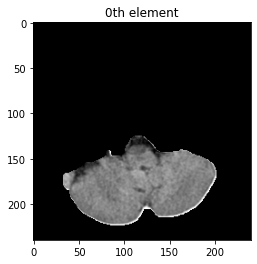

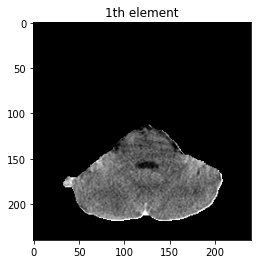

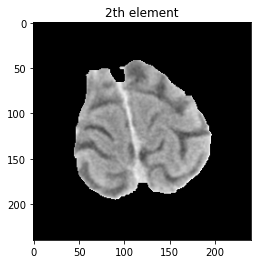

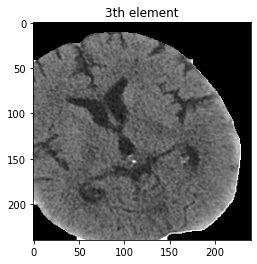

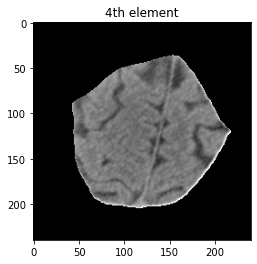

<Figure size 432x288 with 0 Axes>

In [335]:
for i,imagee in enumerate(negative_list[:5]):
    plt.imshow(imagee)
    plt.title(str(i)+"th element")
    plt.figure()

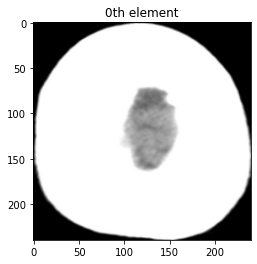

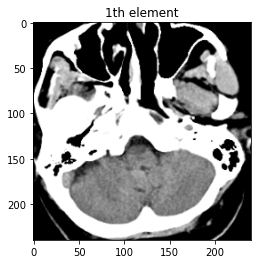

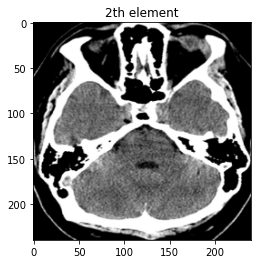

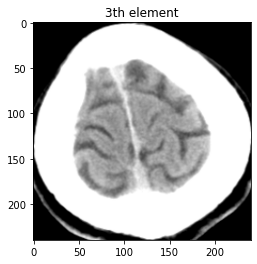

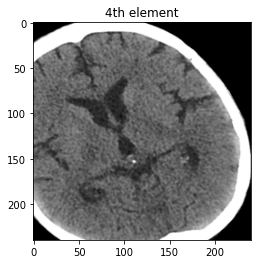

<Figure size 432x288 with 0 Axes>

In [336]:
for j,imageee in enumerate(positive_list[:5]):
    plt.imshow(imageee)
    plt.title(str(j)+"th element")
    plt.figure()

In [64]:
#egemen=positive_list[10000:]
egemen=negative_list

In [65]:
import random
random.shuffle(egemen)
# [4, 3, 2, 1, 0]

In [66]:
random.shuffle(egemen)

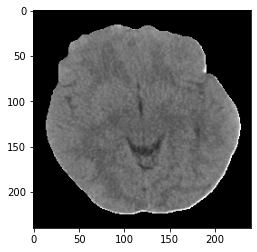

In [67]:
plt.imshow(egemen[0])

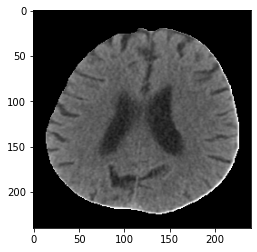

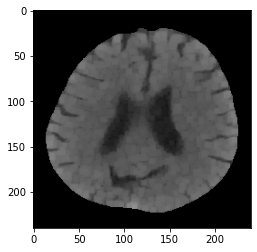

In [95]:
img=egemen[0]
gray1 = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#thresh=crop_brain_contour(thresh)
ret, thresh1 = cv2.threshold(img, 200, 240, cv2.THRESH_TOZERO_INV)
#thresh = crop_brain_contour(thresh1)
kernel = np.ones((5,5),np.uint8)
img2 = cv2.morphologyEx(thresh1, cv2.MORPH_OPEN, kernel)
#img = cv2.erode(img,kernel,iterations = 1)
#ShowImage('Opening',opening,'gray')
plt.imshow(img,cmap="gray")
plt.figure()
plt.imshow(img2,cmap="gray")

In [143]:
os.remove(file) for file in os.listdir("./DATA/TRAIN/Var/") if file.endswith('.png')

SyntaxError: invalid syntax (<ipython-input-143-d0b57eeb5f32>, line 1)

In [348]:
!ls ./DATA/TRAIN/Yok/

1.png    1787.png 2574.png 3361.png 4149.png 4937.png 5724.png 6511.png
10.png   1788.png 2575.png 3362.png 415.png  4938.png 5725.png 6512.png
100.png  1789.png 2576.png 3363.png 4150.png 4939.png 5726.png 6513.png
1000.png 179.png  2577.png 3364.png 4151.png 494.png  5727.png 6514.png
1001.png 1790.png 2578.png 3365.png 4152.png 4940.png 5728.png 6515.png
1002.png 1791.png 2579.png 3366.png 4153.png 4941.png 5729.png 6516.png
1003.png 1792.png 258.png  3367.png 4154.png 4942.png 573.png  6517.png
1004.png 1793.png 2580.png 3368.png 4155.png 4943.png 5730.png 6518.png
1005.png 1794.png 2581.png 3369.png 4156.png 4944.png 5731.png 6519.png
1006.png 1795.png 2582.png 337.png  4157.png 4945.png 5732.png 652.png
1007.png 1796.png 2583.png 3370.png 4158.png 4946.png 5733.png 6520.png
1008.png 1797.png 2584.png 3371.png 4159.png 4947.png 5734.png 6521.png
1009.png 1798.png 2585.png 3372.png 416.png  4948.png 5735.png 6522.png
101.png  1799.png 2586.png 3373.png 4160.png 4949.png 5736.png 65

In [72]:
#deleting the images inside of the file
import os
path222 = './DATA/TRAIN/Yok/'
folder_path = (r'./DATA/TRAIN/Yok/')
for file in tqdm(os.listdir(path222)):
    if file.endswith('.png'):
        try:
            os.remove(os.path.join(folder_path, file))
        except:
            print("there is no suchfile as .png")

100%|██████████| 7000/7000 [00:00<00:00, 12086.53it/s]


In [70]:
#deleting the images inside of the file
import os
path222 = './DATA/TEST/Yok/'
folder_path = (r'./DATA/TEST/Yok/')
for file in tqdm(os.listdir(path222)):
    if file.endswith('.png'):
        try:
            os.remove(os.path.join(folder_path, file))
        except:
            print("there is no suchfile as .png")

100%|██████████| 400/400 [00:00<00:00, 8810.59it/s]


In [69]:
#deleting the images inside of the file
import os
path222 = './DATA/VAl/Yok/'
folder_path = (r'./DATA/VAL/Yok/')
for file in tqdm(os.listdir(path222)):
    if file.endswith('.png'):
        try:
            os.remove(os.path.join(folder_path, file))
        except:
            print("there is no suchfile as .png")

100%|██████████| 2500/2500 [00:00<00:00, 8364.00it/s]


In [77]:
len(negative_list)

9031

In [78]:
from PIL import Image
counter=1
for i in tqdm(negative_list[:6500]):
    #cv2.imwrite(str(counter) + '.png', positive_list[counter])
    im = Image.fromarray(i)
    im.save("./DATA/TRAIN/Yok/"+str(counter)+".png","PNG")
    counter = counter+1

100%|██████████| 6500/6500 [00:50<00:00, 128.27it/s]


In [355]:
counter=1
for i in tqdm(negative_list[6500:8500]):
    #cv2.imwrite(str(counter) + '.png', positive_list[counter])
    im = Image.fromarray(i)
    im.save("./DATA/VAL/Yok/"+str(counter)+".png","PNG")
    counter = counter+1

100%|██████████| 2500/2500 [00:19<00:00, 126.69it/s]


In [356]:
len(negative_list)

9567

In [357]:
counter=1
for i in tqdm(negative_list[8500:]):
    #cv2.imwrite(str(counter) + '.png', positive_list[counter])
    im = Image.fromarray(i)
    im.save("./DATA/TEST/Yok/"+str(counter)+".png","PNG")
    counter = counter+1

100%|██████████| 400/400 [00:03<00:00, 129.90it/s]


In [141]:
counter=1
for i in tqdm(egemen[9500:]):
    #cv2.imwrite(str(counter) + '.png', positive_list[counter])
    im = Image.fromarray(i)
    im.save("./DATA/TEST/Var/"+str(counter)+".png","PNG")
    counter = counter+1

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:16<00:00, 30.56it/s]


In [358]:
def anlık(path, up, down):
    counter=1
    for i in tqdm(negative_list[down:up]):
        #cv2.imwrite(str(counter) + '.png', positive_list[counter])
        im = Image.fromarray(i)
        im.save(path+str(counter)+".png","PNG")
        counter = counter+1

# CHECKPOINT

In [ ]:
path2333 = './DATA/TRAIN/Yok/'
path3333 = test yok ...

In [57]:
img = np.array(positive_list)
lbl = np.array(label_list)

In [58]:
X_train, X_test,y_train, y_test = train_test_split(img,lbl, test_size=0.1,random_state=32, shuffle= True)

In [60]:
from tensorflow.keras.applications.vgg16 import VGG16, decode_predictions, preprocess_input

modelVGG16 = Sequential()
modelVGG16.add(VGG16(include_top=False,pooling='max',weights="imagenet"))
modelVGG16.add(Flatten())
modelVGG16.add(Dense(1024, activation='relu'))
modelVGG16.add(Dropout(0.2))
modelVGG16.add(Dense(1, activation='sigmoid'))

modelVGG16.layers[0].trainable=False

# Compile model 
modelVGG16.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = modelVGG16.fit(X_train,y_train,validation_split=0.1,batch_size=10, epochs=10)

Train on 16200 samples, validate on 1800 samples
Epoch 1/10
16200/16200 [==============================] - 268s 17ms/sample - loss: 0.6295 - accuracy: 0.7376 - val_loss: 0.5514 - val_accuracy: 0.7261
Epoch 2/10
16200/16200 [==============================] - 269s 17ms/sample - loss: 0.4448 - accuracy: 0.7857 - val_loss: 0.4610 - val_accuracy: 0.7778
Epoch 3/10
16200/16200 [==============================] - 261s 16ms/sample - loss: 0.4139 - accuracy: 0.8073 - val_loss: 0.3801 - val_accuracy: 0.8272
Epoch 4/10
 1580/16200 [=>............................] - ETA: 3:33 - loss: 0.4178 - accuracy: 0.8038

In [59]:
del img
del lbl
del positive_list
import gc
gc.collect()

60

In [13]:
scores = modelVGG16.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

2000/2000 [==============================] - 27s 13ms/sample - loss: 0.2956 - accuracy: 0.9285
Test loss: 0.29559927228838206
Test accuracy: 0.9285


C:\Users\hazar\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


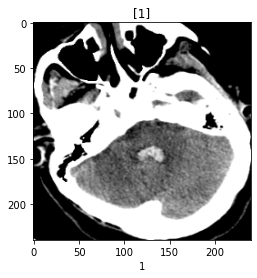

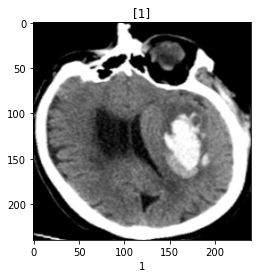

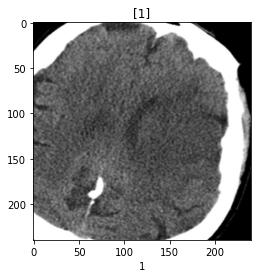

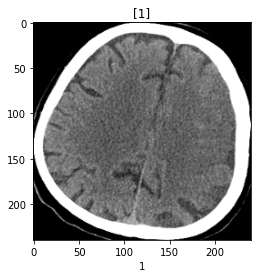

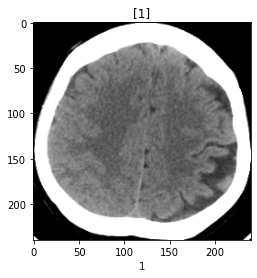

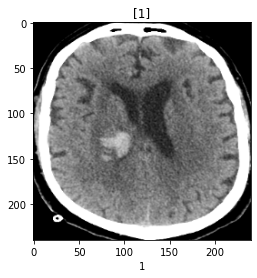

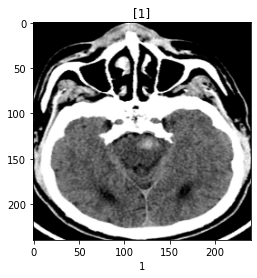

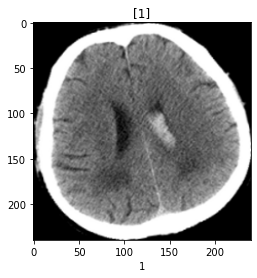

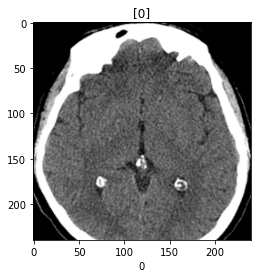

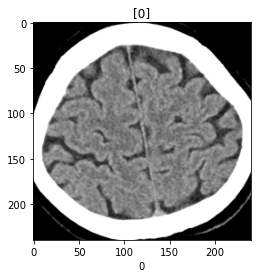

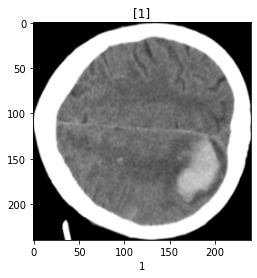

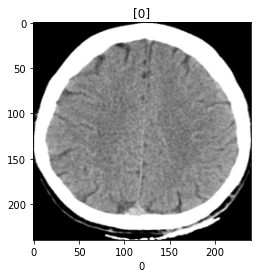

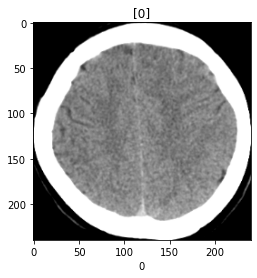

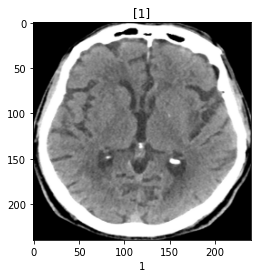

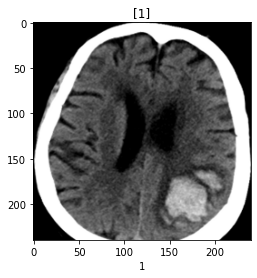

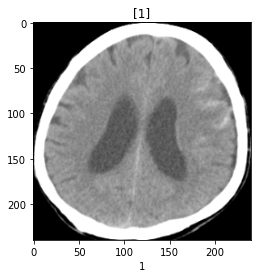

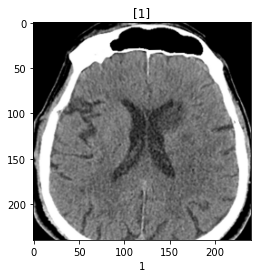

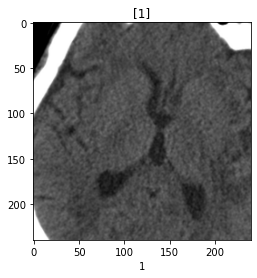

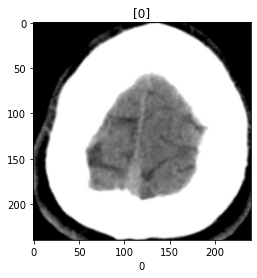

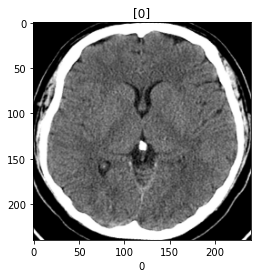

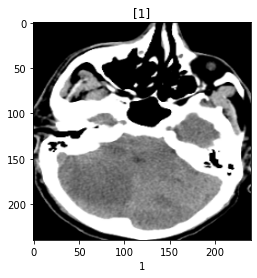

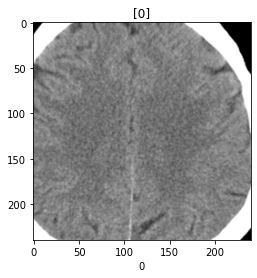

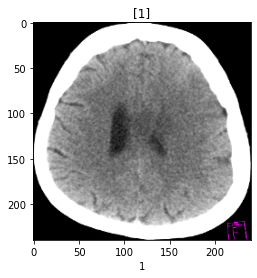

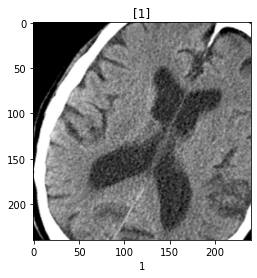

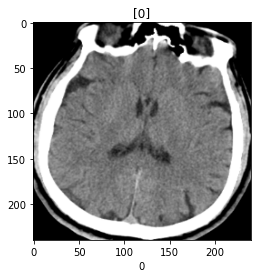

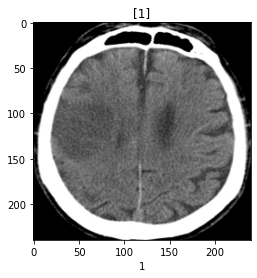

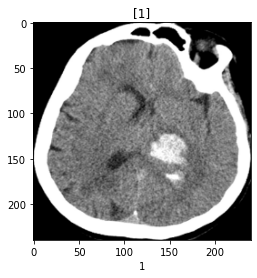

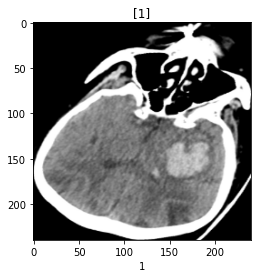

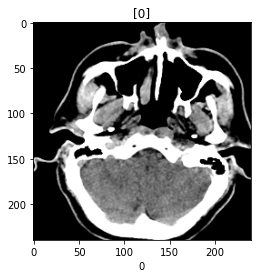

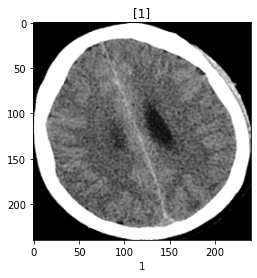

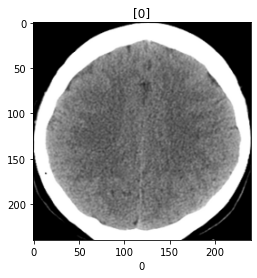

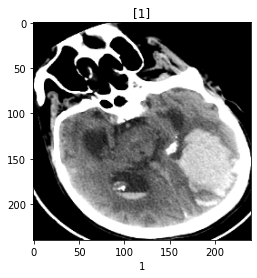

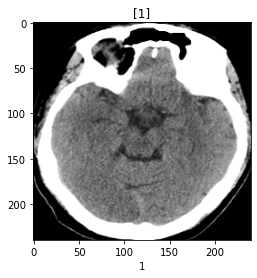

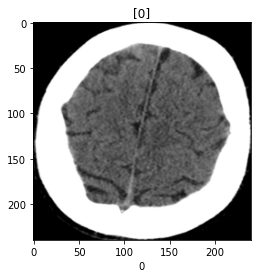

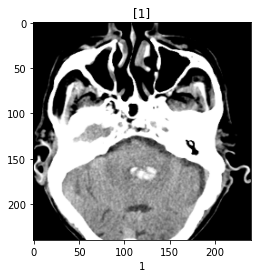

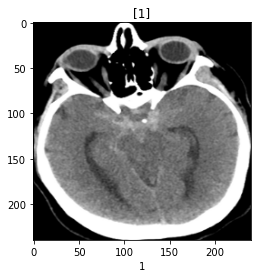

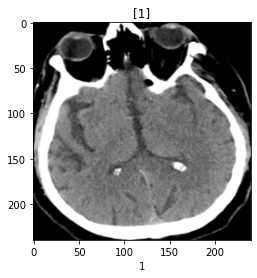

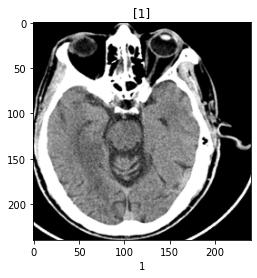

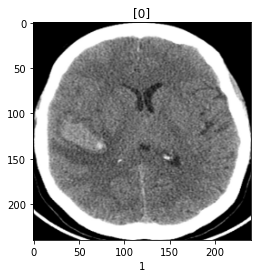

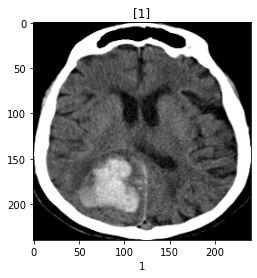

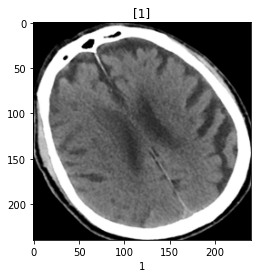

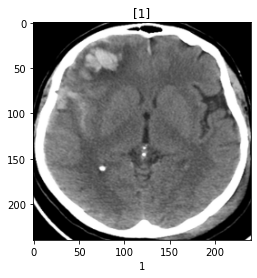

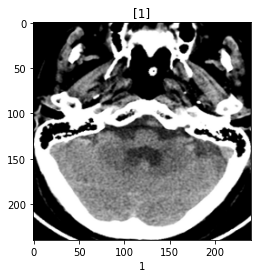

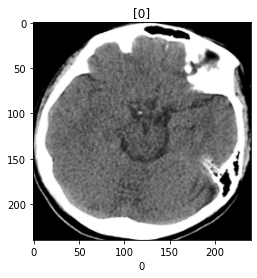

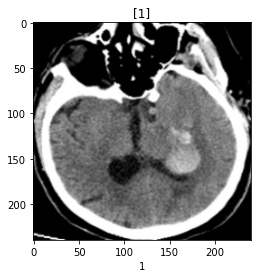

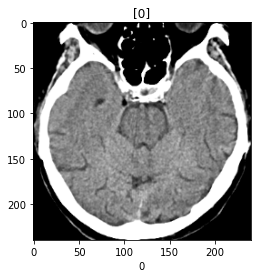

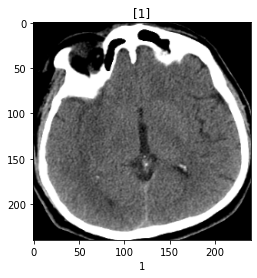

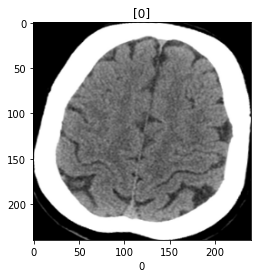

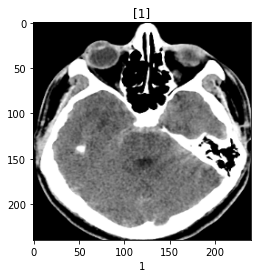

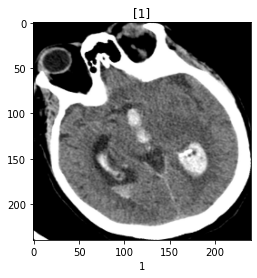

In [15]:
ynew = modelVGG16.predict_classes(X_test)
count = 0
index = 0
for img in X_test[:50]:
    
    plt.figure()
    plt.title(ynew[index])
    plt.xlabel(y_test[index])
    plt.imshow(img)
    index = index +1